In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import punkt, WordPunctTokenizer
from nltk import stem

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import linear_model, svm
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

import gensim
import re

from bs4 import BeautifulSoup
import re
import warnings
import logging
import os
import errno
from collections import defaultdict

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%pylab inline

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['stem']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Read in the sessions.csv and captions.csv files

sessions_data = pd.read_csv('sessions.csv')
captions_data = pd.read_csv('captions.csv')


In [3]:
g = captions_data.columns.to_series().groupby(captions_data.dtypes).groups
g

{dtype('int64'): Index(['id', 'seconds_end', 'seconds_start', 'session_id', 'user_id'], dtype='object'),
 dtype('O'): Index(['caption', 'label', 'youtube_id'], dtype='object')}

In [4]:
# Look to see what type of data we are working with
#list(sessions_data)
list(captions_data)

['caption',
 'id',
 'label',
 'seconds_end',
 'seconds_start',
 'session_id',
 'user_id',
 'youtube_id']

In [5]:
captions_data['caption'].head(5)

0    january thirteenth meeting of the eugene urban...
1    right now on thornton 360 city council recogni...
2    everyone to the July 27 city council\nwork ses...
3    so so if you look at the agenda in front of yo...
4    i know that i did a lot of thinking about the ...
Name: caption, dtype: object

In [6]:
captions_data[(captions_data['session_id'] == 254)]['caption'].head(5)

235      welcome everyone to the october twelfth city c...
1676     transactions and to consult with counsel conce...
4511     to state this general subject of the session a...
5395     session and i welcome the audience back into t...
12751    i think the people who are getting answer the ...
Name: caption, dtype: object

In [7]:
captions_data[(captions_data['session_id'] == 254)]['caption']

235       welcome everyone to the october twelfth city c...
1676      transactions and to consult with counsel conce...
4511      to state this general subject of the session a...
5395      session and i welcome the audience back into t...
12751     i think the people who are getting answer the ...
14499     you want me ask my question yeah it's like whe...
15926     us why okay oh i didn't pull it because i obje...
17103     a very important thing and it's also a lot of ...
18065     measure does and and and and what the money's ...
19274     about the project so and susan peggy from a we...
22035     approval on that i'm gonna let sue fahey who i...
23454     compelling good evening so and what we're requ...
25093     filter replacements we started that with the l...
26222     on either replacing shoring up or doing major ...
27554     basis we're anticipating in the current market...
29022     perspective with the savings we're anticipatin...
30168     and so so this does not includ

In [8]:
captions_data['caption'] = captions_data['caption'].fillna("")
captions_data['caption'] = captions_data['caption'].str.lower()
captions_data['label'] = captions_data['label'].fillna("")
captions_data['label'] = captions_data['label'].str.lower()

# there is a variable called session_id: if two entries have the same session id should we concatenate the caption?
# what is a user_id?  person speaking?  why isn't it combined if its same session id and user id?
captions_data['session_id']
captions_data.loc[captions_data['session_id'] == 254]
captions_data[(captions_data['session_id'] == 254) & (captions_data['user_id'] == 134)]
captions_data[(captions_data['session_id'] == 254)]['caption']



235       welcome everyone to the october twelfth city c...
1676      transactions and to consult with counsel conce...
4511      to state this general subject of the session a...
5395      session and i welcome the audience back into t...
12751     i think the people who are getting answer the ...
14499     you want me ask my question yeah it's like whe...
15926     us why okay oh i didn't pull it because i obje...
17103     a very important thing and it's also a lot of ...
18065     measure does and and and and what the money's ...
19274     about the project so and susan peggy from a we...
22035     approval on that i'm gonna let sue fahey who i...
23454     compelling good evening so and what we're requ...
25093     filter replacements we started that with the l...
26222     on either replacing shoring up or doing major ...
27554     basis we're anticipating in the current market...
29022     perspective with the savings we're anticipatin...
30168     and so so this does not includ

In [9]:
# assume that a session_id is a document
documents = {}
for index, row in captions_data.iterrows():
    if row['caption'] != "":
        if str(row['session_id']) in documents.keys():
            documents[str(row['session_id'])] = documents[str(row['session_id'])] + " " + row['caption']
        else:
            documents[str(row['session_id'])] = row['caption']
        


In [10]:
print(len(documents.keys()))

1637


In [11]:
print(documents['254'])

welcome everyone to the october twelfth city council work session we're going to go into executive session first eugene city council will now meet an executive session negotiate build property transactions and to consult with counsel concerning the legal rights and duties of a public body with regard to current litigation or erations during executive session except to state this general subject of the session as previously announced no session no decision may be made in executive session at the end of executive session we will return to open session and i welcome the audience back into the room so let me know when we're ready to conclude our he sent an email um okay i think i was on the rest of it i think the people who are getting answer the question oh he's on our way in there it rest of the consent calendar please indicate one hey not in opposition okay don't here we are cuz you want me ask my question yeah it's like when they come on to him you're up to okay oh there's what's him f

In [29]:
# LDA is similar to BOW and TF-IDF, but is a higher level representation of a document
# It is also considered topic modeling and can be really useful
# We use the same data cleaning and tokenization for LDA as we did for BOW and TF-IDF
# You should choose the number of topics - for this example we will use the number of topics
# This method may not work so well for binary classification (good vs bad), but it wouldn't hurt to try

#topics = len(newsgroups_train.target_names)


vectorizer = CountVectorizer(analyzer = "word")
train_data_features = vectorizer.fit_transform(documents.values())
num_topics = 50

probs_dict = {}
for num in range(10,num_topics, 10):
    lda_model = LatentDirichletAllocation(n_components=num, random_state=42, learning_method = 'batch')
    train_lda_features = lda_model.fit_transform(train_data_features)
    probs_dict[num_topics] = train_lda_features
    #print(train_lda_features[:2])


KeyboardInterrupt: 

In [21]:
print(probs_dict.keys())
blah = probs_dict[20]
for doc_score in blah:
    print(doc_score)

dict_keys([10, 20, 30, 40])
[  4.06371912e-06   6.02791239e-02   1.19285098e-01   4.15442063e-01
   4.06371912e-06   6.70399590e-02   4.06371912e-06   4.06371912e-06
   4.06371913e-06   4.06371912e-06   4.06371920e-06   4.06371912e-06
   9.57085615e-04   4.06371912e-06   4.06371917e-06   4.06371921e-06
   9.85918873e-04   4.06371921e-06   3.35957924e-01   4.06371921e-06]
[  2.63435196e-05   2.63435202e-05   2.63435202e-05   4.65737205e-02
   2.63435195e-05   2.63435202e-05   2.63435195e-05   2.63435196e-05
   2.63435199e-05   2.63435195e-05   6.17868240e-01   2.63435195e-05
   8.94250601e-02   2.63435195e-05   2.63435199e-05   1.75622859e-01
   5.53657541e-02   1.17751701e-02   3.02673036e-03   2.63435201e-05]
[  3.82263008e-06   4.67344009e-02   1.15704422e-01   1.95008477e-01
   3.82262997e-06   7.06214375e-02   3.82262997e-06   3.82262997e-06
   3.82262999e-06   3.82262997e-06   3.82263005e-06   3.82262997e-06
   4.80384734e-03   3.82262997e-06   3.82263003e-06   3.82263006e-06
   3

   3.45065570e-06   3.45065568e-06   2.72055159e-02   3.45065570e-06]
[  5.20941864e-06   4.92705887e-01   5.20941875e-06   3.70612891e-01
   5.20941863e-06   1.29800729e-01   5.20941863e-06   5.20941863e-06
   5.20941867e-06   5.20941863e-06   5.20941875e-06   5.20941863e-06
   6.45105861e-03   5.20941863e-06   5.20941870e-06   5.20941876e-06
   5.20941875e-06   5.20941875e-06   5.20941875e-06   3.51293192e-04]
[  3.90076463e-06   7.57096966e-02   4.58346005e-02   1.42533509e-01
   3.90076455e-06   5.42388753e-01   3.90076455e-06   3.90076455e-06
   3.90076456e-06   3.90076455e-06   3.90076463e-06   3.90076455e-06
   1.65703885e-02   3.90076455e-06   3.90076461e-06   1.45250547e-02
   3.90076464e-06   3.90076464e-06   9.07899726e-02   7.16012161e-02]
[  2.69251496e-05   2.69251487e-05   2.69251488e-05   2.69251487e-05
   2.69251481e-05   2.69251488e-05   2.69251481e-05   2.69251481e-05
   2.69251482e-05   2.69251481e-05   8.13237055e-01   2.69251481e-05
   1.38727756e-01   2.69251481e

[  5.02512563e-05   5.02512574e-05   4.04316448e-01   5.02512574e-05
   5.02512563e-05   1.29344385e-01   5.02512563e-05   5.02512563e-05
   5.02512564e-05   5.02512563e-05   5.02512573e-05   5.02512563e-05
   3.46872570e-03   5.02512563e-05   5.02512571e-05   6.44216809e-02
   3.68000813e-01   2.97444293e-02   5.02512575e-05   5.02512574e-05]
[  5.67988192e-06   8.69313250e-02   2.42121398e-03   1.32861384e-01
   5.67988186e-06   1.92498282e-01   5.67988186e-06   5.67988186e-06
   5.67988187e-06   5.67988186e-06   5.67988198e-06   5.67988186e-06
   1.05378067e-01   5.67988186e-06   5.67988195e-06   2.28121483e-01
   1.81757900e-03   5.67988201e-06   1.00234554e-01   1.49673634e-01]
[  3.71885464e-06   6.46039833e-01   3.71885468e-06   9.30647429e-02
   3.71885459e-06   2.42712551e-01   3.71885459e-06   3.71885459e-06
   3.71885466e-06   3.71885459e-06   3.71885468e-06   3.71885459e-06
   3.71885468e-06   3.71885459e-06   3.71885465e-06   3.58222730e-03
   1.45448624e-02   3.71885469e-

[  3.07749124e-06   6.55175361e-01   1.58179885e-01   2.82183961e-02
   3.07749123e-06   7.91498084e-02   3.07749123e-06   3.07749123e-06
   3.07749124e-06   3.07749123e-06   3.07749130e-06   3.07749123e-06
   5.94903636e-03   3.07749123e-06   3.07749128e-06   3.07749130e-06
   6.43853050e-03   3.07749130e-06   3.79675848e-03   6.30552944e-02]
[  2.76762981e-06   4.96606484e-01   1.13715782e-01   8.03345378e-02
   2.76762980e-06   2.30820025e-01   2.76762980e-06   2.76762982e-06
   2.76762985e-06   2.76762980e-06   2.61068249e-04   2.76762980e-06
   2.76762987e-06   2.76762980e-06   2.76762985e-06   2.76762987e-06
   6.55068525e-02   1.69168516e-03   2.76762987e-06   1.10303546e-02]
[  3.68677189e-06   2.58079596e-03   6.90297472e-02   1.09053650e-01
   3.68677186e-06   1.50037942e-01   3.68677186e-06   3.68677186e-06
   3.68677187e-06   3.68677186e-06   3.68677194e-06   3.68677186e-06
   3.68677195e-06   3.68677186e-06   3.68677191e-06   2.01471996e-02
   7.44348015e-02   3.68677194e-

   2.00264309e-01   7.98842735e-03   3.52883925e-04   6.79410848e-03]
[  5.18887507e-06   7.61019702e-02   5.18887517e-06   4.53151792e-01
   5.18887505e-06   3.35137418e-01   5.18887505e-06   5.18887505e-06
   5.18887507e-06   5.18887505e-06   5.18887516e-06   5.18887505e-06
   5.18887517e-06   5.18887505e-06   5.18887512e-06   7.54755699e-02
   6.27800082e-04   5.18887517e-06   5.94328062e-02   5.18887517e-06]
[  3.36451115e-06   3.36451121e-06   2.16792581e-02   4.14346593e-02
   3.36451114e-06   1.02087926e-02   3.36451114e-06   3.36451114e-06
   3.36451115e-06   3.36451114e-06   3.36451121e-06   3.36451114e-06
   3.36451121e-06   3.36451114e-06   3.36451120e-06   3.36451121e-06
   6.54737844e-01   6.18588685e-03   1.81115685e-01   8.45941360e-02]
[  5.64780304e-06   5.64780314e-06   7.18257922e-01   2.25902277e-02
   5.64780300e-06   1.10677156e-01   5.64780300e-06   5.64780301e-06
   5.64780301e-06   5.64780300e-06   5.64780313e-06   5.64780300e-06
   5.64780312e-06   5.64780300e

In [28]:
max_prob_scores = []
gini_scores = []
for i in probs_dict.keys(): #this is 1, 2, 3, up to max number of topics
    my_matrix = probs_dict[i] #this is the matrix
    maxes = []
    g_probs = []
    for row in my_matrix:
        maxes.append(max(row))
        for element in row:
            g_probs.append(element * (1-element))
    max_prob_scores.append(sum(maxes)/len(maxes))
    gini_scores.append(sum(g_probs)/len(g_probs))

print(len(gini_scores))
print(num_topics)
for i in range(10,num_topics, 10):
    print(i)

4
40
10
20
30


ValueError: x and y must be the same size

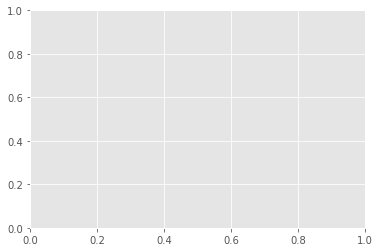

In [24]:
plt.scatter(range(10,num_topics, 10), gini_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Gini Index")
plt.ylim((0,1))
plt.title("Mean Gini Index by Number of Topics")

ValueError: x and y must be the same size

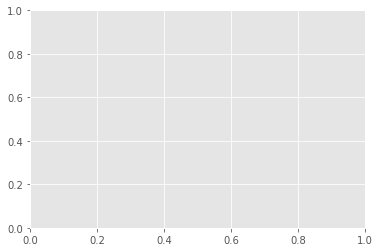

In [19]:
plt.scatter(range(10,num_topics, 10), max_prob_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Max Probability Index")
plt.ylim((0,1))
plt.title("Mean Max Probability by Number of Topics")